In [38]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gd
import seaborn as sns
import importlib
import pickle

# functions for this project
import multithreadTD as models



In [39]:
# simulation parameters
dt = 0.1
d_max = int(8/dt)
t_max = int(9/dt)

tpts = np.arange(0,t_max*dt,dt)



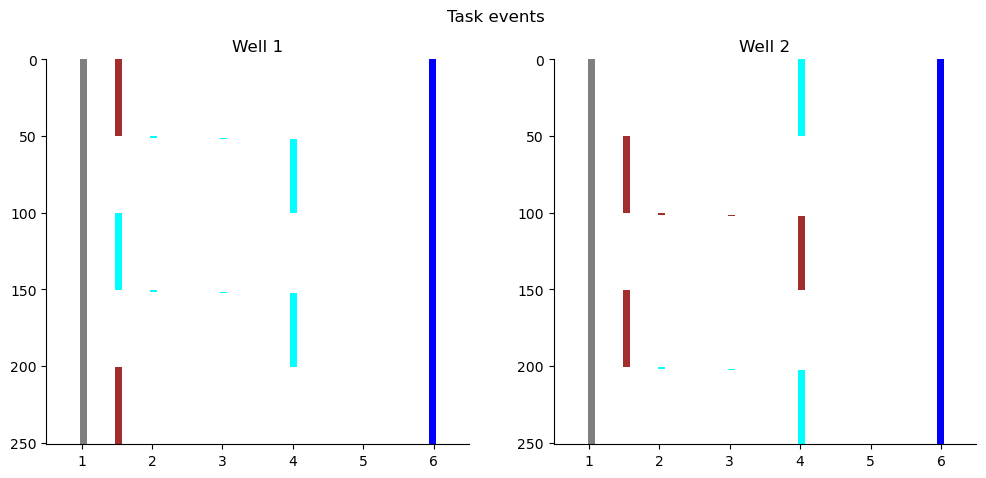

In [40]:
# task events
# we want both the delay and identity transitions
blocktr = 50
nblock = 5
ntr = blocktr*nblock

importlib.reload(models)
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# cue == 1, terminal reward == 2, chocolate == 3, vanilla == 4

well1, well2 = models.createTask(dt,t_max,ntr,blocktr)

colors = ["white", "gray", "blue", "brown","cyan"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

fig,ax = plt.subplots(1,2,figsize=[12,5])
w1 = ax[0].imshow(well1,aspect='auto',cmap=cmap1,extent=[tpts[0],tpts[-1],ntr+1,0],interpolation="nearest")
ax[0].set_title('Well 1')
ax[0].set(xlim=[0.5,6.5])
# fig.colorbar(w1,ax=ax[0])
w2 = ax[1].imshow(well2,aspect='auto',cmap=cmap1,extent=[tpts[0],tpts[-1],ntr+1,0],interpolation="nearest")
ax[1].set_title('Well 2')
ax[1].set(xlim=[0.5,6.5])
# fig.colorbar(w2,ax=ax[1])

fig.suptitle('Task events')

sns.despine()



# Multi-prediction TD models

## 1. multi-TD($\lambda$) with id-specific reset AND transition update

T (241, 241)
O (241, 241, 5)
taskstates (241, 4)


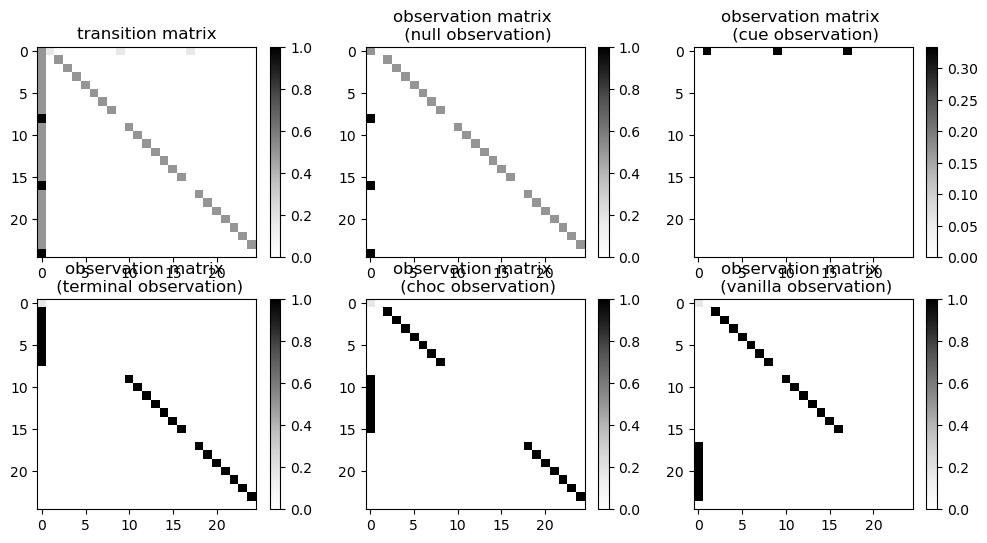

In [41]:
importlib.reload(models)

nstates = int(d_max) + 1 # timepoint states for cued states and single ITI state
model = 5
nids = 3 # choc, vanilla, terminal

threads = [[0],np.arange(1,d_max+1),np.arange(d_max+1,d_max*2+1),np.arange(d_max*2+1,d_max*3+1)]

T,O,taskstates = models.buildWorldModel(model,threads)

# check we have the right shape for this number of identities
print(f'T {T.shape}')
print(f'O {O.shape}')
print(f'taskstates {taskstates.shape}') # nids + 1 for background


# M maps between states and the vector prediction space (dim nid) 
M = np.zeros([nids,T.shape[0]])

M[:,0] = 1/3
M[0,threads[1]] = 1
M[1,threads[2]] = 1
M[2,threads[3]] = 1

# print(M.shape)

# map observations to reward amount and identity 
reward = np.zeros([nids+1,O.shape[1]]) # one for background
reward[1,2] = 1
reward[2,3] = 1
reward[3,4] = 1

reward = np.zeros([nids,O.shape[1]])
reward[0,2] = 1
reward[1,3] = 1
reward[2,4] = 1

# print(reward.shape)

# plot these to check
nplot = 8
plotthreads = [[0],np.arange(1,nplot+1),np.arange(nplot+1,nplot*2+1),np.arange(nplot*2+1,nplot*3+1)]

plotT,plotO,plotTask = models.buildWorldModel(model,plotthreads)

fig,ax = plt.subplots(2,3,figsize=[12,6])
ax = ax.ravel()

c1 = ax[0].imshow(plotT,aspect='auto',cmap='Greys',interpolation='nearest')

ax[0].set_title('transition matrix')
fig.colorbar(c1, ax=ax[0])

c2 = ax[1].imshow(plotO[:,:,0],aspect='auto',cmap='Greys',interpolation='nearest')
ax[1].set_title('observation matrix \n (null observation)')
fig.colorbar(c2, ax=ax[1])

c3 = ax[2].imshow(plotO[:,:,1],aspect='auto',cmap='Greys',interpolation='nearest')
ax[2].set_title('observation matrix \n (cue observation)')
fig.colorbar(c3, ax=ax[2])

c4 = ax[3].imshow(plotO[:,:,2],aspect='auto',cmap='Greys',interpolation='nearest')
ax[3].set_title('observation matrix \n (terminal observation)')
fig.colorbar(c4, ax=ax[3])

c5 = ax[4].imshow(plotO[:,:,3],aspect='auto',cmap='Greys',interpolation='nearest')
ax[4].set_title('observation matrix \n (choc observation)')
fig.colorbar(c5, ax=ax[4])

c6 = ax[5].imshow(plotO[:,:,4],aspect='auto',cmap='Greys',interpolation='nearest')
ax[5].set_title('observation matrix \n (vanilla observation)')
fig.colorbar(c6, ax=ax[5])





In [42]:
# run this structure

importlib.reload(models)

# eta = 0.4
# gamma = 0.95
# elambda = 1
# decay = 0.0005 # 0.001/2 to account for partial belief in any one thread

eta = 0.4
gamma = 0.95
elambda = 1
decay = 0.1 # 0.1

# transition learning rate
t_eta = 0.5
# indices of initial states in threads for transition learning
stream_start = np.array([threads[1][0],threads[2][0],threads[3][0]],dtype='int') 

with open('init_weights_multithread.pickle','rb') as f:
    d = pickle.load(f)

state1, nextstate1, w1, elig1, v1, nextv1, rpe1, thread1, tmatrix1 = models.TDlambda_vectorErrorTupdate(well1, T, O, M, M.T, taskstates, reward, eta, gamma, elambda, decay, t_eta, stream_start, d['init_w'])

# print(reward.shape)

In [43]:
# and the second well

state2, nextstate2, w2, elig2, v2, nextv2, rpe2, thread2, tmatrix2 = models.TDlambda_vectorErrorTupdate(well2, T, O, M, M.T, taskstates, reward, eta, gamma, elambda, decay, t_eta, stream_start, d['init_w'])



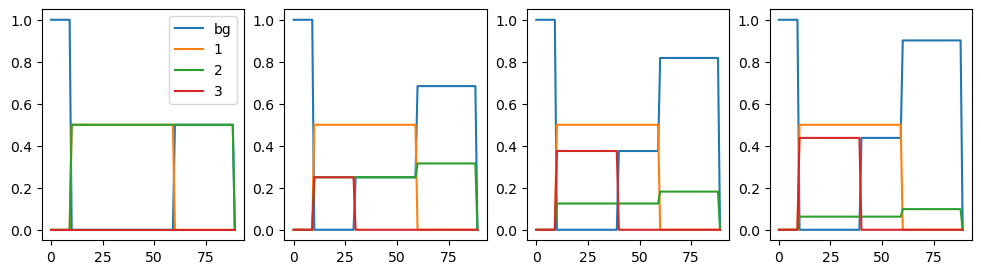

In [44]:
# check state trajectories using the taskstates

tr = 50

fig,ax = plt.subplots(1,4,figsize=[12,3])

ax[0].plot((np.squeeze(state1[tr,:,:]).T)@taskstates)
ax[0].legend(['bg','1','2','3'])
ax[1].plot(thread1[tr+1,:,:].T)
ax[2].plot(thread1[tr+2,:,:].T)
ax[3].plot(thread1[tr+3,:,:].T)
# ax[0].plot(thread1[tr,:,:].T,linestyle='--')

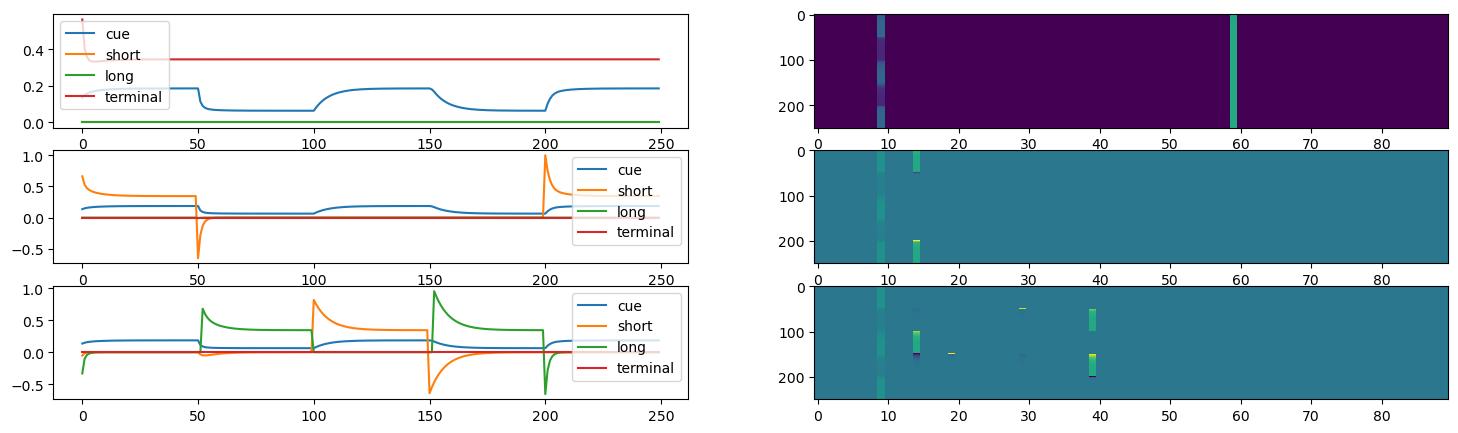

In [45]:
# our rpe signals are now vector
# corresponding to the different types of possible outcomes

# RPE through task

t_cue = np.where(tpts==1)[0][0] - 1
t_short = np.where(tpts==1.5)[0][0] - 1
t_long = np.where(tpts==4)[0][0] - 1
t_terminal = np.where(tpts==6)[0][0] - 1

fig,ax = plt.subplots(3,2,figsize=[18,5])

for chan in range(3):
    ax[chan,0].plot(rpe1[:,chan,[t_cue,t_short,t_long,t_terminal]])
    ax[chan,0].legend(['cue','short','long','terminal'])

    ax[chan,1].imshow(rpe1[:,chan,:],aspect='auto',interpolation='nearest')

Text(0.5, 0.98, 'Well 1')

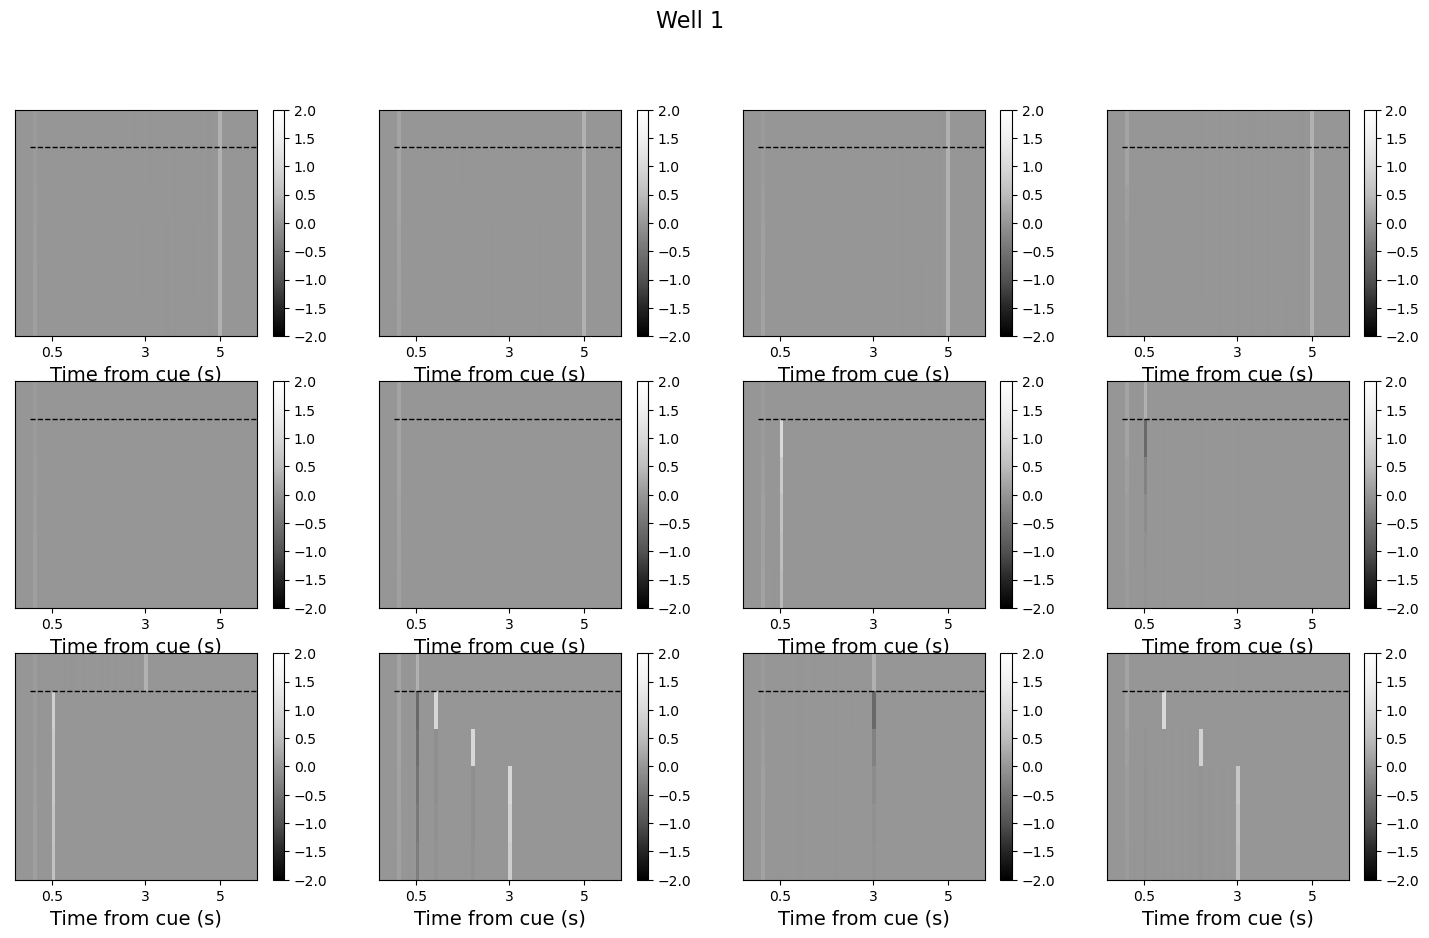

In [46]:
# check out the RPE for each condition across reward channels

colors = ["darkblue","blue", "lightgray", "red","darkred"]
cmap2 = LinearSegmentedColormap.from_list("mycmap", colors)

xfont = 14
xlim = 6

cmap = cmap2
# cmap = 'jet'
cmap='Greys_r'

shortsame1 = rpe1[(blocktr*2-1):(blocktr*2+5),:,:]
shortsame2 = rpe2[(blocktr*3-1):(blocktr*3+5),:,:]
longsame1 = rpe1[(blocktr*3-1):(blocktr*3+5),:,:]
longsame2 = rpe2[(blocktr*2-1):(blocktr*2+5),:,:]
shortdiff1 = rpe1[(blocktr*4-1):(blocktr*4+5),:,:]
shortdiff2 = rpe2[(blocktr-1):(blocktr+5):,:]
longdiff1 = rpe1[(blocktr-1):(blocktr+5),:,:]
longdiff2 = rpe2[(blocktr*4-1):(blocktr*4+5),:,:]


fig,ax = plt.subplots(3,4,figsize=[18,10]) # we have these for each channel

for chan in [0,1,2]:

    cbar = ax[chan,0].imshow(shortsame1[:,chan,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
    ax[chan,0].set(xlim=[0.5,xlim+1])
    ax[chan,0].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
    ax[chan,0].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
    ax[chan,0].set_xlabel('Time from cue (s)',fontsize=xfont)
    fig.colorbar(cbar,ax=ax[chan,0])

    cbar = ax[chan,1].imshow(longsame1[:,chan,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
    ax[chan,1].set(xlim=[0.5,xlim+1])
    ax[chan,1].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
    ax[chan,1].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
    ax[chan,1].set_xlabel('Time from cue (s)',fontsize=xfont)
    fig.colorbar(cbar,ax=ax[chan,1])

    cbar = ax[chan,2].imshow(shortdiff1[:,chan,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
    ax[chan,2].set(xlim=[0.5,xlim+1])
    ax[chan,2].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
    ax[chan,2].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
    ax[chan,2].set_xlabel('Time from cue (s)',fontsize=xfont)
    fig.colorbar(cbar,ax=ax[chan,2])

    cbar = ax[chan,3].imshow(longdiff1[:,chan,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
    ax[chan,3].set(xlim=[0.5,xlim+1])
    ax[chan,3].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
    ax[chan,3].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
    ax[chan,3].set_xlabel('Time from cue (s)',fontsize=xfont)
    fig.colorbar(cbar,ax=ax[chan,3])

fig.suptitle('Well 1',fontsize=16)    


# plt.savefig('multiTD_idReset_fullRPE_well1.png', bbox_inches="tight")




Text(0.5, 0.98, 'Well 2')

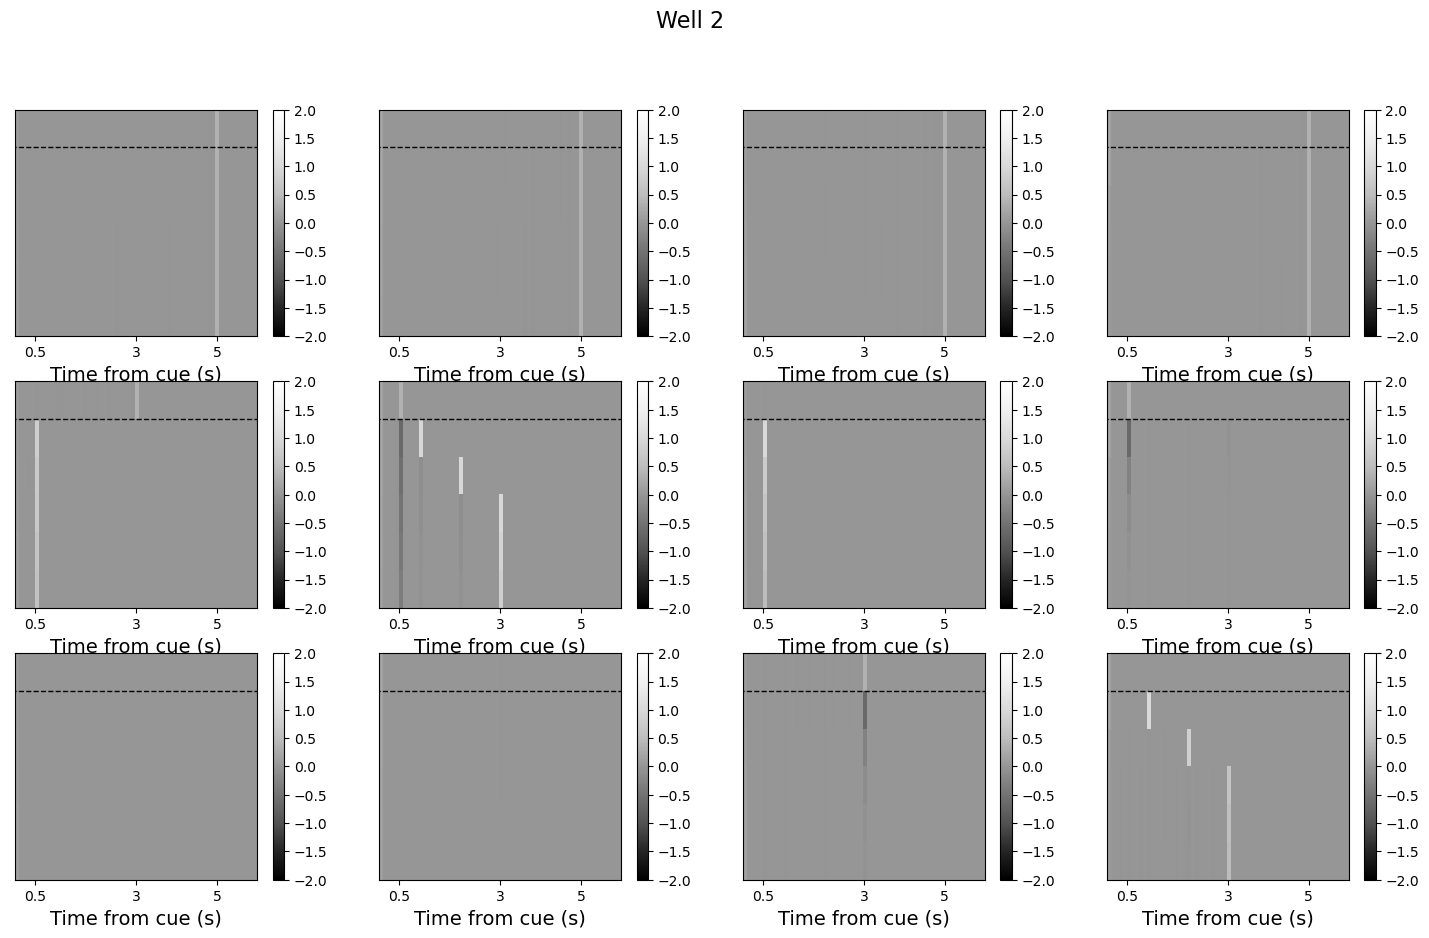

In [47]:
# and well 2

fig,ax = plt.subplots(3,4,figsize=[18,10]) # we have these for each channel

for chan in [0,1,2]:

    cbar = ax[chan,0].imshow(shortsame2[:,chan,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
    ax[chan,0].set(xlim=[1,xlim+1])
    ax[chan,0].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
    ax[chan,0].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
    ax[chan,0].set_xlabel('Time from cue (s)',fontsize=xfont)
    fig.colorbar(cbar,ax=ax[chan,0])

    cbar = ax[chan,1].imshow(longsame2[:,chan,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
    ax[chan,1].set(xlim=[1,xlim+1])
    ax[chan,1].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
    ax[chan,1].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
    ax[chan,1].set_xlabel('Time from cue (s)',fontsize=xfont)
    fig.colorbar(cbar,ax=ax[chan,1])

    cbar = ax[chan,2].imshow(shortdiff2[:,chan,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
    ax[chan,2].set(xlim=[1,xlim+1])
    ax[chan,2].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
    ax[chan,2].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
    ax[chan,2].set_xlabel('Time from cue (s)',fontsize=xfont)
    fig.colorbar(cbar,ax=ax[chan,2])

    cbar = ax[chan,3].imshow(longdiff2[:,chan,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
    ax[chan,3].set(xlim=[1,xlim+1])
    ax[chan,3].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
    ax[chan,3].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
    ax[chan,3].set_xlabel('Time from cue (s)',fontsize=xfont)
    fig.colorbar(cbar,ax=ax[chan,3])

fig.suptitle('Well 2',fontsize=16)    


# plt.savefig('multiTD_idReset_fullRPE_well2.png', bbox_inches="tight")



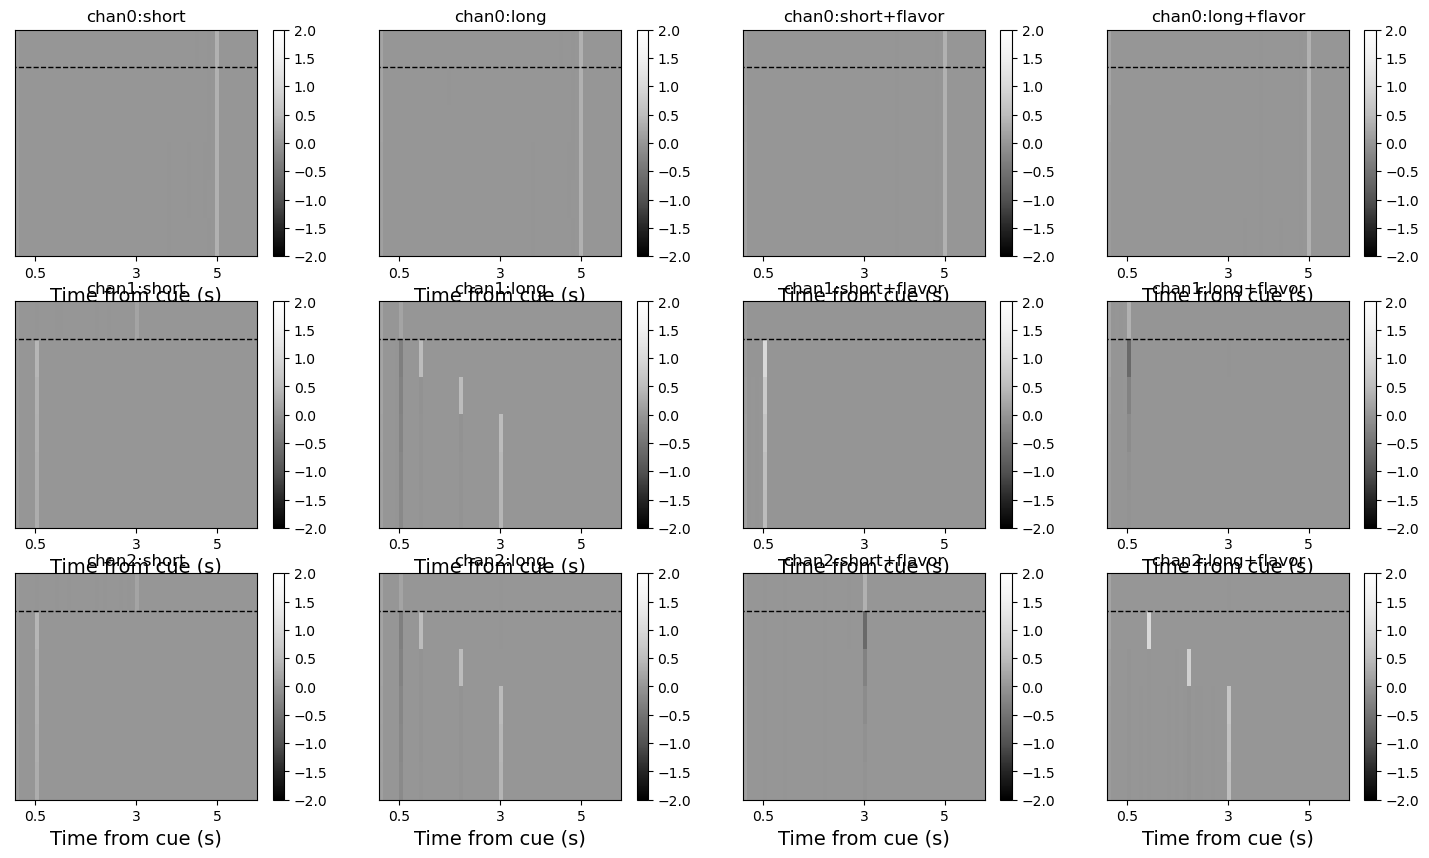

In [48]:
# full model figure of combined conditions

cmap = cmap2
# cmap = 'jet'
cmap = "Greys_r"

fig,ax = plt.subplots(3,4,figsize=[18,10]) # we have these for each channel

for chan in [0,1,2]:

    cbar = ax[chan,0].imshow((shortsame1[:,chan,:]+shortsame2[:,chan,:])/2,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
    ax[chan,0].set(xlim=[1,xlim+1])
    ax[chan,0].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
    ax[chan,0].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
    ax[chan,0].set_xlabel('Time from cue (s)',fontsize=xfont)
    ax[chan,0].set_title('chan'+str(chan)+':short')
    fig.colorbar(cbar,ax=ax[chan,0])

    cbar = ax[chan,1].imshow((longsame1[:,chan,:]+longsame2[:,chan,:])/2,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
    ax[chan,1].set(xlim=[1,xlim+1])
    ax[chan,1].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
    ax[chan,1].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
    ax[chan,1].set_xlabel('Time from cue (s)',fontsize=xfont)
    ax[chan,1].set_title('chan'+str(chan)+':long')
    fig.colorbar(cbar,ax=ax[chan,1])

    cbar = ax[chan,2].imshow((shortdiff1[:,chan,:]+shortdiff2[:,chan,:])/2,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
    ax[chan,2].set(xlim=[1,xlim+1])
    ax[chan,2].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
    ax[chan,2].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
    ax[chan,2].set_xlabel('Time from cue (s)',fontsize=xfont)
    ax[chan,2].set_title('chan'+str(chan)+':short+flavor')
    fig.colorbar(cbar,ax=ax[chan,2])

    cbar = ax[chan,3].imshow((longdiff1[:,chan,:]+longdiff2[:,chan,:])/2,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
    ax[chan,3].set(xlim=[1,xlim+1])
    ax[chan,3].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
    ax[chan,3].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
    ax[chan,3].set_xlabel('Time from cue (s)',fontsize=xfont)
    ax[chan,3].set_title('chan'+str(chan)+':long+flavor')
    fig.colorbar(cbar,ax=ax[chan,3])




Text(0.43, 0.98, 'weights in well 1')

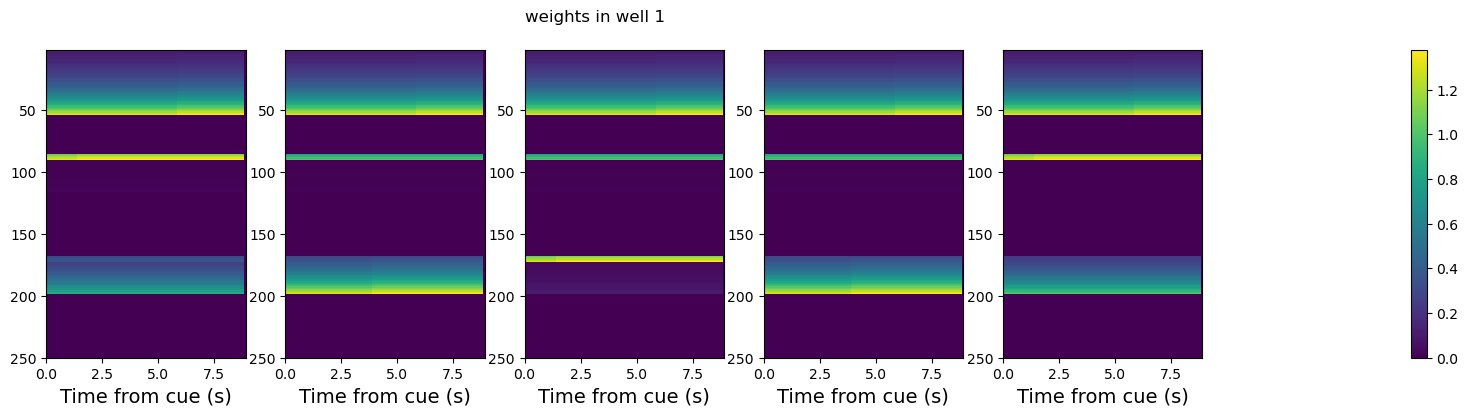

In [49]:
# check the weights...

# well 1: weights at end of block 1,2,3,4,5

fig,ax = plt.subplots(1,6,figsize=[18,4])


cbar = ax[0].imshow(w1[blocktr-1,:,:],aspect='auto',interpolation='nearest',extent=[tpts[0],tpts[-1],250,1])
ax[0].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[1].imshow(w1[blocktr*2-1,:,:],aspect='auto',interpolation='nearest',extent=[tpts[0],tpts[-1],250,1])
ax[1].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[2].imshow(w1[blocktr*3-1,:,:],aspect='auto',interpolation='nearest',extent=[tpts[0],tpts[-1],250,1])
ax[2].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[3].imshow(w1[blocktr*4-1,:,:],aspect='auto',interpolation='nearest',extent=[tpts[0],tpts[-1],250,1])
ax[3].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[4].imshow(w1[blocktr*5-1,:,:],aspect='auto',interpolation='nearest',extent=[tpts[0],tpts[-1],250,1])
ax[4].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[5].axis('off')

fig.colorbar(cbar,ax=ax[5])


fig.suptitle('weights in well 1',x=0.43)

Text(0.43, 0.98, 'weights in well 2')

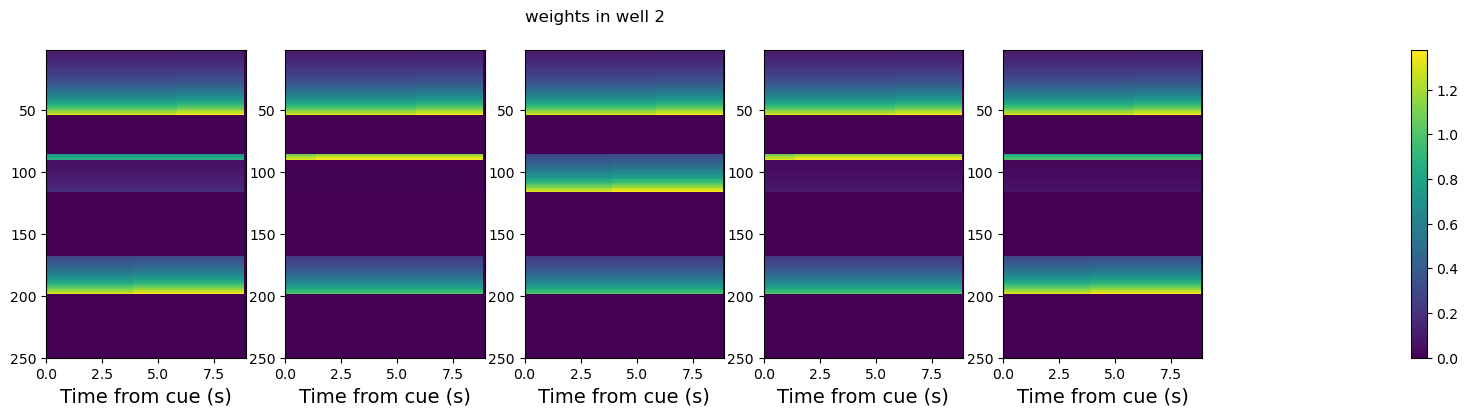

In [50]:
# check the weights...

# well 2: weights at end of block 1,2,3,4,5

fig,ax = plt.subplots(1,6,figsize=[18,4])


cbar = ax[0].imshow(w2[blocktr-1,:,:],aspect='auto',interpolation='nearest',extent=[tpts[0],tpts[-1],250,1])
ax[0].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[1].imshow(w2[blocktr*2-1,:,:],aspect='auto',interpolation='nearest',extent=[tpts[0],tpts[-1],250,1])
ax[1].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[2].imshow(w2[blocktr*3-1,:,:],aspect='auto',interpolation='nearest',extent=[tpts[0],tpts[-1],250,1])
ax[2].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[3].imshow(w2[blocktr*4-1,:,:],aspect='auto',interpolation='nearest',extent=[tpts[0],tpts[-1],250,1])
ax[3].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[4].imshow(w2[blocktr*5-1,:,:],aspect='auto',interpolation='nearest',extent=[tpts[0],tpts[-1],250,1])
ax[4].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[5].axis('off')

fig.colorbar(cbar,ax=ax[5])


fig.suptitle('weights in well 2',x=0.43)

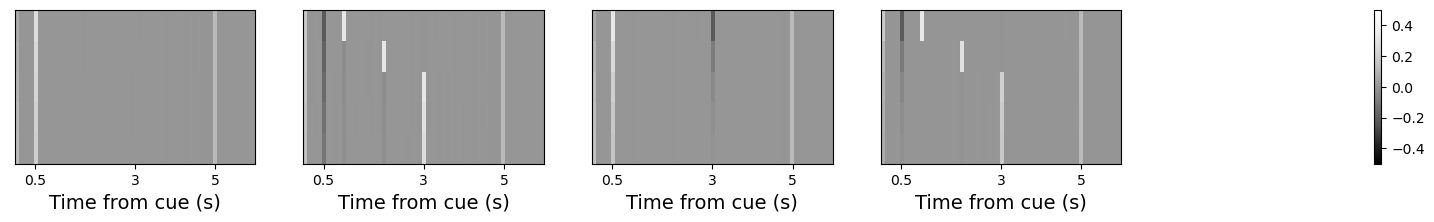

In [51]:
# and average across channels


cmap = cmap2
# cmap = 'jet'
cmap = "Greys_r"

clim = 0.5

fig,ax = plt.subplots(1,5,figsize=[18,2])

cbar = ax[0].imshow((shortsame1[1:,:]+shortsame2[1:,:]).mean(axis=1)/2,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-clim,vmax=clim)
ax[0].set(xlim=[1,xlim+1])
# ax[0].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[0].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[0].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[1].imshow((longsame1[1:,:]+longsame2[1:,:]).mean(axis=1)/2,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-clim,vmax=clim)
ax[1].set(xlim=[1,xlim+1])
# ax[1].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[1].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[1].set_xlabel('Time from cue (s)',fontsize=xfont)


cbar = ax[2].imshow((shortdiff1[1:,:]+shortdiff2[1:,:]).mean(axis=1)/2,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-clim,vmax=clim)
ax[2].set(xlim=[1,xlim+1])
# ax[2].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[2].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[2].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[3].imshow((longdiff1[1:,:]+longdiff2[1:,:]).mean(axis=1)/2,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-clim,vmax=clim)
ax[3].set(xlim=[1,xlim+1])
# ax[3].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[3].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[3].set_xlabel('Time from cue (s)',fontsize=xfont)


ax[4].axis('off')

fig.colorbar(cbar,ax=ax[4])


# plt.savefig('multiTD_idReset_avRPE.png', bbox_inches="tight")



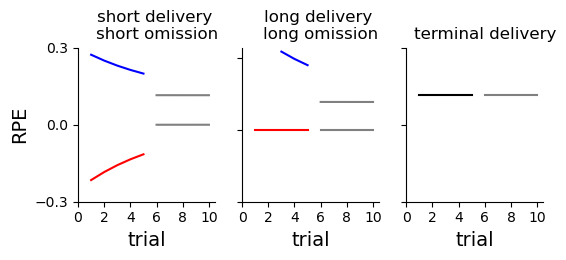

In [52]:

# plot RPE through block for DELAY ONLY

fig,ax = plt.subplots(1,3,figsize=[6,2.0])

shortdelivery1_early = (rpe1[blocktr*2:(blocktr*2+5),:,t_short] + rpe2[blocktr*3:(blocktr*3+5),:,t_short])/2
shortomission1_early = (rpe1[blocktr*3:(blocktr*3+5),:,t_short] + rpe2[blocktr*2:(blocktr*2+5),:,t_short])/2
shortdelivery1_late = (rpe1[(blocktr*3-5):blocktr*3,:,t_short] + rpe2[(blocktr*2-5):blocktr*2,:,t_short])/2
shortomission1_late = (rpe1[(blocktr*2-5):blocktr*2,:,t_short] + rpe2[(blocktr*3-5):blocktr*3,:,t_short])/2

longdelivery1_early = (rpe1[(blocktr*3+2):(blocktr*3+5),:,t_long] + rpe2[(blocktr*2+2):(blocktr*2+5),:,t_long])/2
longomission1_early = (rpe1[blocktr*2:(blocktr*2+5),:,t_long] + rpe2[blocktr*3:(blocktr*3+5),:,t_long])/2
longdelivery1_late = (rpe1[(blocktr*4-5):blocktr*4,:,t_long] + rpe2[(blocktr*3-5):blocktr*3,:,t_long])/2
longomission1_late = (rpe1[(blocktr*3-5):blocktr*3,:,t_long] + rpe2[(blocktr*4-5):blocktr*4,:,t_long])/2


terminaldelivery1_early = (rpe1[blocktr*2:(blocktr*2+5),:,t_terminal] + \
                          rpe1[blocktr*3:(blocktr*3+5),:,t_terminal] + \
                          rpe2[blocktr*2:(blocktr*2+5),:,t_terminal] + \
                          rpe2[blocktr*3:(blocktr*3+5),:,t_terminal])/4
terminaldelivery1_late = (rpe1[(blocktr*3-5):blocktr*3,:,t_terminal] + \
                          rpe1[(blocktr*4-5):blocktr*4,:,t_terminal] + \
                          rpe2[(blocktr*3-5):blocktr*3,:,t_terminal] + \
                          rpe2[(blocktr*4-5):blocktr*4,:,t_terminal])/4

ax[0].plot(np.arange(1,6),shortdelivery1_early.mean(axis=1),color='blue')
ax[0].plot(np.arange(6,11),shortdelivery1_late.mean(axis=1),color='Grey')
ax[0].plot(np.arange(1,6),shortomission1_early.mean(axis=1),color='red')
ax[0].plot(np.arange(6,11),shortomission1_late.mean(axis=1),color='Grey')
ax[0].set(ylabel='RPE',xlabel='trial',yticks=[0.3,0,-0.3],xticks=np.arange(0,11,2))
ax[0].xaxis.label.set_fontsize(xfont)
ax[0].yaxis.label.set_fontsize(xfont)
ax[0].set_title("    short delivery \n    short omission",fontsize=12)

ax[1].plot(np.arange(3,6),longdelivery1_early.mean(axis=1),color='blue')
ax[1].plot(np.arange(6,11),longdelivery1_late.mean(axis=1),color='Grey')
ax[1].plot(np.arange(1,6),longomission1_early.mean(axis=1),color='red')
ax[1].plot(np.arange(6,11),longomission1_late.mean(axis=1),color='grey')
ax[1].set(xlabel='trial',yticks=[0.3,0,-0.3],xticks=np.arange(0,11,2),yticklabels=[])
ax[1].xaxis.label.set_fontsize(xfont)
ax[1].yaxis.label.set_fontsize(xfont)
# ax[1].plot(0,rpe[blocktr*3,t_late1],color='red',marker='.')
# ax[1].plot(1,rpe[blocktr*3+1,t_late2],color='red',marker='.')
ax[1].set_title("    long delivery \n    long omission",fontsize=12)

ax[2].plot(np.arange(1,6),terminaldelivery1_early.mean(axis=1),color='k')
ax[2].plot(np.arange(6,11),terminaldelivery1_late.mean(axis=1),color='grey')
ax[2].set(xlabel='trial',yticks=[0.3,0,-0.3],xticks=np.arange(0,11,2),yticklabels=[])
ax[2].xaxis.label.set_fontsize(xfont)
ax[2].yaxis.label.set_fontsize(xfont)
ax[2].set_title('    terminal delivery',fontsize=12)


sns.despine()


# plt.savefig('multiTD_delayOnly_features.png', bbox_inches="tight")




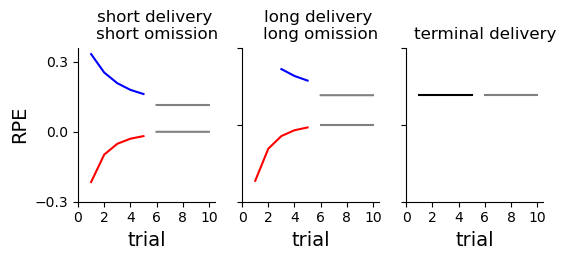

In [53]:

# plot RPE through block for DELAY-FLAVOR

fig,ax = plt.subplots(1,3,figsize=[6,2.0])

shortdelivery2_early = (rpe1[blocktr*4:(blocktr*4+5),:,t_short] + rpe2[blocktr:(blocktr+5),:,t_short])/2
shortomission2_early = (rpe1[blocktr:(blocktr+5),:,t_short] + rpe2[blocktr*4:(blocktr*4+5),:,t_short])/2
shortdelivery2_late = (rpe1[(blocktr*5-5):blocktr*5,:,t_short] + rpe2[(blocktr*2-5):blocktr*2,:,t_short])/2
shortomission2_late = (rpe1[(blocktr*2-5):blocktr*2,:,t_short] + rpe2[(blocktr*5-5):blocktr*5,:,t_short])/2

longdelivery2_early = (rpe1[(blocktr+2):(blocktr+5),:,t_long] + rpe2[(blocktr*4+2):(blocktr*4+5),:,t_long])/2
longomission2_early = (rpe1[blocktr*4:(blocktr*4+5),:,t_long] + rpe2[blocktr:(blocktr+5),:,t_long])/2
longdelivery2_late = (rpe1[(blocktr*2-5):blocktr*2,:,t_long] + rpe2[(blocktr*5-5):blocktr*5,:,t_long])/2
longomission2_late = (rpe1[(blocktr*5-5):blocktr*5,:,t_long] + rpe2[(blocktr*2-5):blocktr*2,:,t_long])/2


terminaldelivery2_early = (rpe1[blocktr:(blocktr+5),:,t_terminal] + \
                          rpe1[blocktr*4:(blocktr*4+5),:,t_terminal] + \
                          rpe2[blocktr:(blocktr+5),:,t_terminal] + \
                          rpe2[blocktr*4:(blocktr*4+5),:,t_terminal])/4
terminaldelivery2_late = (rpe1[(blocktr*2-5):blocktr*2,:,t_terminal] + \
                          rpe1[(blocktr*5-5):blocktr*5,:,t_terminal] + \
                          rpe2[(blocktr*2-5):blocktr*2,:,t_terminal] + \
                          rpe2[(blocktr*5-5):blocktr*5,:,t_terminal])/4

ax[0].plot(np.arange(1,6),shortdelivery2_early.mean(axis=1),color='blue')
ax[0].plot(np.arange(6,11),shortdelivery2_late.mean(axis=1),color='Grey')
ax[0].plot(np.arange(1,6),shortomission2_early.mean(axis=1),color='red')
ax[0].plot(np.arange(6,11),shortomission2_late.mean(axis=1),color='Grey')
ax[0].set(ylabel='RPE',xlabel='trial',yticks=[0.3,0,-0.3],xticks=np.arange(0,11,2))
ax[0].xaxis.label.set_fontsize(xfont)
ax[0].yaxis.label.set_fontsize(xfont)
ax[0].set_title("    short delivery \n    short omission",fontsize=12)

ax[1].plot(np.arange(3,6),longdelivery2_early.mean(axis=1),color='blue')
ax[1].plot(np.arange(6,11),longdelivery2_late.mean(axis=1),color='Grey')
ax[1].plot(np.arange(1,6),longomission2_early.mean(axis=1),color='red')
ax[1].plot(np.arange(6,11),longomission2_late.mean(axis=1),color='grey')
ax[1].set(xlabel='trial',yticks=[0.3,0,-0.3],xticks=np.arange(0,11,2),yticklabels=[])
ax[1].xaxis.label.set_fontsize(xfont)
ax[1].yaxis.label.set_fontsize(xfont)
# ax[1].plot(0,rpe[blocktr*3,t_late1],color='red',marker='.')
# ax[1].plot(1,rpe[blocktr*3+1,t_late2],color='red',marker='.')
ax[1].set_title("    long delivery \n    long omission",fontsize=12)

ax[2].plot(np.arange(1,6),terminaldelivery2_early.mean(axis=1),color='k')
ax[2].plot(np.arange(6,11),terminaldelivery2_late.mean(axis=1),color='grey')
ax[2].set(xlabel='trial',yticks=[0.3,0,-0.3],xticks=np.arange(0,11,2),yticklabels=[])
ax[2].xaxis.label.set_fontsize(xfont)
ax[2].yaxis.label.set_fontsize(xfont)
ax[2].set_title('    terminal delivery',fontsize=12)


sns.despine()


# plt.savefig('multiTD_delayFlavor_features.png', bbox_inches="tight")




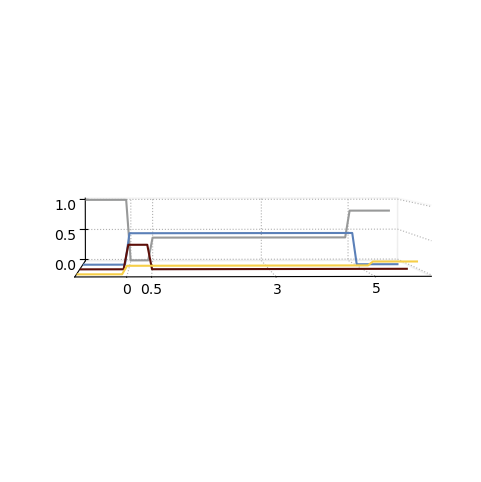

In [54]:
# state evolution to show transition learning

col_vanilla = np.array([246,206,70])/255
col_choc = np.array([93,14,8])/255
col_terminal = np.array([91,128,184])/255
col_bg = np.array([152,153,153])/255

fig = plt.figure(figsize=(6,6))

belief = (thread2[blocktr-1,:,:])
belief2 = (thread2[blocktr,:,:])
belief3 = (thread2[blocktr+1,:,:])
belief4 = (thread2[blocktr+2,:,:])
belief5 = (thread2[blocktr+3,:,:])

ax[0] = fig.add_subplot(111,projection='3d')

tend = np.where(tpts==7)[0][0]
ax[0].plot3D(tpts[:tend],tpts[:tend]*0+1.5,belief4[0,:tend],color=col_bg)
ax[0].plot3D(tpts[:tend],tpts[:tend]*0+1,belief4[1,:tend],color=col_terminal)
ax[0].plot3D(tpts[:tend],tpts[:tend]*0+0.5,belief4[2,:tend],color=col_choc)
ax[0].plot3D(tpts[:tend],tpts[:tend]*0,belief4[3,:tend],color=col_vanilla)

ax[0].azim = -92
ax[0].elev = 2

ax[0].set(xticks=1+np.array([0,0.5,3,5]),xticklabels=['0','0.5','3','5'],yticks=[],zticks=[0,0.5,1])
# ax[0].set_xlabel('Time from cue (s)',fontsize=xfont)
ax[0].set(xlim=[0+dt,xlim+1])


ax[0].xaxis.pane.fill = False
ax[0].yaxis.pane.fill = False
ax[0].zaxis.pane.fill = False


ax[0].xaxis._axinfo["grid"]['linestyle'] = ":"
ax[0].yaxis._axinfo["grid"]['linestyle'] = ":"
ax[0].zaxis._axinfo["grid"]['linestyle'] = ":"

ax[0].set_box_aspect(aspect = (1,1,0.2))


# plt.savefig('multiTD_stateProgression_4.png', dpi=300, bbox_inches="tight")



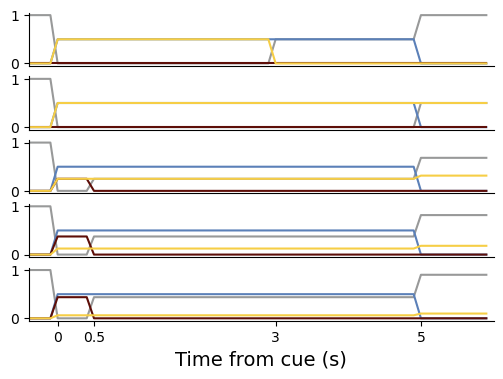

In [55]:
# state evolution to show transition learning
# 2-D version

col_vanilla = np.array([246,206,70])/255
col_choc = np.array([93,14,8])/255
col_terminal = np.array([91,128,184])/255
col_bg = np.array([152,153,153])/255

fig,ax = plt.subplots(5,1,figsize=(6,4))

belief = (thread2[blocktr-1,:,:])
belief2 = (thread2[blocktr,:,:])
belief3 = (thread2[blocktr+1,:,:])
belief4 = (thread2[blocktr+2,:,:])
belief5 = (thread2[blocktr+3,:,:])


tend = np.where(tpts==7)[0][0]
ax[0].plot(tpts[:tend],belief[0,:tend],color=col_bg)
ax[0].plot(tpts[:tend],belief[1,:tend],color=col_terminal)
ax[0].plot(tpts[:tend],belief[2,:tend],color=col_choc)
ax[0].plot(tpts[:tend],belief[3,:tend],color=col_vanilla)

ax[0].set(xticks=[],yticks=[0,1])
ax[0].set(xlim=[0.5+dt,xlim+1])

ax[1].plot(tpts[:tend],belief2[0,:tend],color=col_bg)
ax[1].plot(tpts[:tend],belief2[1,:tend],color=col_terminal)
ax[1].plot(tpts[:tend],belief2[2,:tend],color=col_choc)
ax[1].plot(tpts[:tend],belief2[3,:tend],color=col_vanilla)

ax[1].set(xticks=[],yticks=[0,1])
ax[1].set(xlim=[0.5+dt,xlim+1])


ax[2].plot(tpts[:tend],belief3[0,:tend],color=col_bg)
ax[2].plot(tpts[:tend],belief3[1,:tend],color=col_terminal)
ax[2].plot(tpts[:tend],belief3[2,:tend],color=col_choc)
ax[2].plot(tpts[:tend],belief3[3,:tend],color=col_vanilla)

ax[2].set(xticks=[],yticks=[0,1])
ax[2].set(xlim=[0.5+dt,xlim+1])


ax[3].plot(tpts[:tend],belief4[0,:tend],color=col_bg)
ax[3].plot(tpts[:tend],belief4[1,:tend],color=col_terminal)
ax[3].plot(tpts[:tend],belief4[2,:tend],color=col_choc)
ax[3].plot(tpts[:tend],belief4[3,:tend],color=col_vanilla)

ax[3].set(xticks=[],yticks=[0,1])
ax[3].set(xlim=[0.5+dt,xlim+1])


ax[4].plot(tpts[:tend],belief5[0,:tend],color=col_bg)
ax[4].plot(tpts[:tend],belief5[1,:tend],color=col_terminal)
ax[4].plot(tpts[:tend],belief5[2,:tend],color=col_choc)
ax[4].plot(tpts[:tend],belief5[3,:tend],color=col_vanilla)

ax[4].set(xticks=[],yticks=[0,1])
ax[4].set(xlim=[0.5+dt,xlim+1])

ax[4].set(xticks=1+np.array([0,0.5,3,5]),xticklabels=['0','0.5','3','5'])
ax[4].set_xlabel('Time from cue (s)',fontsize=xfont)

sns.despine()

# plt.savefig('multiTD_stateProgression_2d.png', dpi=300, bbox_inches="tight")



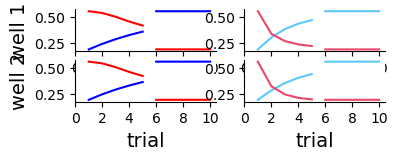

In [56]:
# multithread cue response

t1 = np.where(tpts==1)[0][0] - 1
t2 = np.where(tpts==1.5)[0][0] - 1
t3 = np.where(tpts==4)[0][0] - 1
t4 = np.where(tpts==6)[0][0] - 1

block2 = 50
block3 = 100
block4 = 150
block5 = 200

c3 = np.array([92,201,250])/255
c4 = np.array([234,72,105])/255

shortcue_well1_early = rpe1[block3:(block3+5),:,t1]
shortcue_well2_early = rpe2[block4:(block4+5),:,t1]
shortcue_well1_late = rpe1[(block3+45):block4,:,t1]
shortcue_well2_late = rpe2[(block4+45):block5,:,t1]
longcue_well1_early = rpe1[block4:(block4+5),:,t1]
longcue_well2_early = rpe2[block3:(block3+5),:,t1]
longcue_well1_late = rpe1[(block4+45):block5,:,t1]
longcue_well2_late = rpe2[(block3+45):block4,:,t1]

shortflavorcue_well1_early = rpe1[block5:(block5+5),:,t1]
shortflavorcue_well2_early = rpe2[block2:(block2+5),:,t1]
shortflavorcue_well1_late = rpe1[(block5+45):(block5+50),:,t1]
shortflavorcue_well2_late = rpe2[(block2+45):block3,:,t1]
longflavorcue_well1_early = rpe1[block2:(block2+5),:,t1]
longflavorcue_well2_early = rpe2[block5:(block5+5),:,t1]
longflavorcue_well1_late = rpe1[(block2+45):block3,:,t1]
longflavorcue_well2_late = rpe2[(block5+45):(block5+50),:,t1]

fig,ax = plt.subplots(2,2,figsize=[4,1.2])
ax = ax.ravel()

ax[0].plot(np.arange(1,6),shortcue_well1_early.sum(axis=1),color='blue')
ax[0].plot(np.arange(6,11),shortcue_well1_late.sum(axis=1),color='blue')
ax[0].plot(np.arange(1,6),longcue_well1_early.sum(axis=1),color='red')
ax[0].plot(np.arange(6,11),longcue_well1_late.sum(axis=1),color='red')
ax[0].set(xlabel='trial',xticks=np.arange(0,11,2),ylabel='well 1')
ax[0].xaxis.label.set_fontsize(xfont)
ax[0].yaxis.label.set_fontsize(xfont)

ax[1].plot(np.arange(1,6),shortflavorcue_well1_early.sum(axis=1),color=c3)
ax[1].plot(np.arange(6,11),shortflavorcue_well1_late.sum(axis=1),color=c3)
ax[1].plot(np.arange(1,6),longflavorcue_well1_early.sum(axis=1),color=c4)
ax[1].plot(np.arange(6,11),longflavorcue_well1_late.sum(axis=1),color=c4)
ax[1].set(xlabel='trial',xticks=np.arange(0,11,2))
ax[1].xaxis.label.set_fontsize(xfont)
ax[1].yaxis.label.set_fontsize(xfont)

ax[2].plot(np.arange(1,6),shortcue_well2_early.sum(axis=1),color='blue')
ax[2].plot(np.arange(6,11),shortcue_well2_late.sum(axis=1),color='blue')
ax[2].plot(np.arange(1,6),longcue_well2_early.sum(axis=1),color='red')
ax[2].plot(np.arange(6,11),longcue_well2_late.sum(axis=1),color='red')
ax[2].set(xlabel='trial',xticks=np.arange(0,11,2),ylabel='well 2')
ax[2].xaxis.label.set_fontsize(xfont)
ax[2].yaxis.label.set_fontsize(xfont)

ax[3].plot(np.arange(1,6),shortflavorcue_well2_early.sum(axis=1),color=c3)
ax[3].plot(np.arange(6,11),shortflavorcue_well2_late.sum(axis=1),color=c3)
ax[3].plot(np.arange(1,6),longflavorcue_well2_early.sum(axis=1),color=c4)
ax[3].plot(np.arange(6,11),longflavorcue_well2_late.sum(axis=1),color=c4)
ax[3].set(xlabel='trial',xticks=np.arange(0,11,2))
ax[3].xaxis.label.set_fontsize(xfont)
ax[3].yaxis.label.set_fontsize(xfont)

sns.despine()



# plt.savefig('Figure5a_multithreadTD_cueresponse.png', bbox_inches="tight")


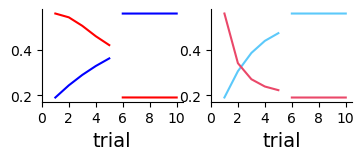

In [57]:

fig,ax = plt.subplots(1,2,figsize=[4,1.2])

ax[0].plot(np.arange(1,6),(shortcue_well1_early.sum(axis=1) + shortcue_well2_early.sum(axis=1))/2,color='blue')
ax[0].plot(np.arange(6,11),(shortcue_well1_late.sum(axis=1) + shortcue_well2_late.sum(axis=1))/2,color='blue')
ax[0].plot(np.arange(1,6),longcue_well1_early.sum(axis=1),color='red')
ax[0].plot(np.arange(6,11),longcue_well1_late.sum(axis=1),color='red')
ax[0].set(xlabel='trial',xticks=np.arange(0,11,2))
ax[0].xaxis.label.set_fontsize(xfont)
ax[0].yaxis.label.set_fontsize(xfont)

ax[1].plot(np.arange(1,6),shortflavorcue_well1_early.sum(axis=1),color=c3)
ax[1].plot(np.arange(6,11),shortflavorcue_well1_late.sum(axis=1),color=c3)
ax[1].plot(np.arange(1,6),longflavorcue_well1_early.sum(axis=1),color=c4)
ax[1].plot(np.arange(6,11),longflavorcue_well1_late.sum(axis=1),color=c4)
ax[1].set(xlabel='trial',xticks=np.arange(0,11,2))
ax[1].xaxis.label.set_fontsize(xfont)
ax[1].yaxis.label.set_fontsize(xfont)


sns.despine()



# plt.savefig('Figure5a_multithreadTD_cueresponse.png', bbox_inches="tight")